# Energy price convergence in 2021

In this example, we will take a look at energy price convergence. 

To do this, we'll look at price forecasts from (30-minute) pre-dispatch ({term}`PREDISPATCH`) and 5-minute pre-dispatch ({term}`P5MIN`). 

We'll also look at the relationship between demand forecast error and energy price convergence.

```{note}
While we use *price error* to refer to the difference between actual prices and forecast prices in some parts of this example, we prefer *price convergence*. The intention of `P5MIN` and `PREDISPATCH` is to provide AEMO and participants with up-to-date system and market information. A potential outcome of this is that participants change their decisions (e.g. rebidding, as we note [here](https://github.com/UNSW-CEEM/NEMSEER#user-content-fn-1-8822583f56aa96a7caaf6d6d5e453504)). As such, prices reported in `P5MIN` and `PREDISPATCH` should not be strictly interpreted as forecasts.
```

## Key imports

In [1]:
# standard libraries
import logging
from datetime import datetime, timedelta
from pathlib import Path
from typing import Tuple

# NEM data libraries
# NEMOSIS for actual demand data
# NEMSEER for forecast demand data
import nemosis
from nemseer import compile_data, download_raw_data, generate_runtimes

# data wrangling libraries
import pandas as pd
import xarray as xr

# interactive plotting
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

# static plotting
import matplotlib
import matplotlib.pyplot as plt

# silence NEMSEER and NEMOSIS logging
logging.getLogger("nemosis").setLevel(logging.WARNING)
logging.getLogger("nemseer").setLevel(logging.ERROR)

## Plot Styling

In [2]:
nemseer_template = dict(
    layout=go.Layout(
        font_family="Source Sans Pro",
        title_font_size=24,
        title_x=0.05,
        plot_bgcolor="#f0f0f0",
        colorway=px.colors.qualitative.Bold,
    )
)
plt.style.use("styling/matplotlib_styling.mplstyle")

## Defining our analysis start and end dates

In [3]:
analysis_start = "2021/01/01 00:00:00"
analysis_end = "2022/01/01 00:00:00"

## Getting Data

In AEMO data tables, the energy price in \$/MW/hr is usually found in the `RRP` column.

We will focus on 5-minute dispatch interval prices.

```{note}
Prior to midnight 30 September (commencement of 5-minute settlement), market settlement prices for energy were calculated as the average of the 6 dispatch interval prices in a half hour window.
```

### Obtaining actual price data from `NEMOSIS`

We will download `DISPATCHPRICE` to access the `RRP` (energy price) field and cache it so that it's ready for computation.

In [4]:
nemosis_cache = Path("nemosis_cache/")
if not nemosis_cache.exists():
    nemosis_cache.mkdir()

In [5]:
nemosis.cache_compiler(
    analysis_start, analysis_end, "DISPATCHPRICE", nemosis_cache, fformat="parquet"
)

### Obtaining actual demand data from `NEMOSIS`

We can download `DISPATCHREGIONSUM` to get actual demand values used in dispatch (`TOTALDEMAND`). 


In [6]:
nemosis.cache_compiler(
    analysis_start, analysis_end, "DISPATCHREGIONSUM", nemosis_cache, fformat="parquet"
)

### Obtaining forecast price data from `NEMSEER`

We will download `PRICE` to access the `RRP` field in `PREDISPATCH` forecasts, and `REGIONSOLUTION` to access the `RRP` field in `P5MIN` forecasts. We'll cache it so that it's ready for computation.

In [7]:
download_raw_data(
    "PREDISPATCH",
    "PRICE",
    "nemseer_cache/",
    forecasted_start=analysis_start,
    forecasted_end=analysis_end,
)


download_raw_data(
    "P5MIN",
    "REGIONSOLUTION",
    "nemseer_cache/",
    forecasted_start=analysis_start,
    forecasted_end=analysis_end,
)

### Obtaining forecast demand data from NEMSEER

We will also download demand data. This is contained within `REGIONSOLUTION` for `P5MIN`, but we need to get the table `REGIONSUM` for `PREDISPATCH`.

In [8]:
download_raw_data(
    "PREDISPATCH",
    "REGIONSUM",
    "nemseer_cache/",
    forecasted_start=analysis_start,
    forecasted_end=analysis_end,
)

## Comparing price (and demand) convergence for a particular time

The code below (toggle to unhide) allows us to plot forecast convergence for price and demand across `PREDISPATCH` and `P5MIN`.

Note that we adjust the *nominal* {term}`run time` to the {term}`actual run time` for both forecast types.

In [9]:
def plot_price_comparison(time: str, regionid: str) -> go.Figure:
    """
    Creates a figure that compares price forecasts from PD & P5MIN against
    the actual price.

    Args:
        time: Datetime string in format YYYY/mm/dd HH:MM:SS
        regionid: One of ("NSW1", "QLD1", "VIC1", "TAS1", "SA1")
    Returns:
        plotly Figure
    """

    def get_actual_data(time: str) -> pd.DataFrame:
        """
        Gets actual price data
        """
        # get actual data from the hour beforehand to the interval of interest
        nemosis_window = (
            (
                datetime.strptime(time, "%Y/%m/%d %H:%M:%S") - timedelta(minutes=60)
            ).strftime("%Y/%m/%d %H:%M:%S"),
            time,
        )
        nemosis_price = nemosis.dynamic_data_compiler(
            nemosis_window[0],
            nemosis_window[1],
            "DISPATCHPRICE",
            nemosis_cache,
            filter_cols=["INTERVENTION"],
            filter_values=([0],),
        )
        actual_price = nemosis_price[["SETTLEMENTDATE", "REGIONID", "RRP"]]
        return actual_price

    def get_forecast_data(time: str) -> Tuple[xr.DataArray, xr.DataArray]:
        """
        Gets P5 and PD forecast price data
        Also corrects nominal to actual run time
        """
        # get P5 and PD forecast data
        ## get PD data
        run_start, run_end = generate_runtimes(time, time, "PREDISPATCH")
        pd_price = compile_data(
            run_start,
            run_end,
            time,
            time,
            "PREDISPATCH",
            "PRICE",
            "nemseer_cache/",
            data_format="xr",
        )["PRICE"]["RRP"]
        ## calculate actual run time from run time, then swap out nominal for actual
        pd_price = pd_price.assign_coords(
            {"actual_run_time": pd_price.coords["run_time"] - pd.Timedelta(30, "T")}
        )
        pd_price = pd_price.swap_dims({"run_time": "actual_run_time"}).drop("run_time")
        ## get P5 data
        p5_price = compile_data(
            run_start,
            run_end,
            time,
            time,
            "P5MIN",
            "REGIONSOLUTION",
            "nemseer_cache/",
            data_format="xr",
        )["REGIONSOLUTION"]["RRP"]
        ## calculate actual run time from run time, then swap out nominal for actual
        p5_price = p5_price.assign_coords(
            {"actual_run_time": p5_price.coords["run_time"] - pd.Timedelta(5, "T")}
        )
        p5_price = p5_price.swap_dims({"run_time": "actual_run_time"}).drop("run_time")
        return pd_price, p5_price

    actual_price = get_actual_data(time).query("REGIONID==@regionid")
    pd_price, p5_price = get_forecast_data(time)
    pd_price = pd_price.sel(REGIONID=regionid)
    p5_price = p5_price.sel(REGIONID=regionid)
    # create plotly figure
    fig = go.Figure(
        layout=dict(
            title=f"Energy Price Comparison: {regionid} {time} <br><sup>Actual run times for forecasts</sup>",
            template=nemseer_template

        ),

    )
    fig.add_traces(
        [
            go.Scatter(
                x=pd_price.isel(forecasted_time=0).to_dataframe().index,
                y=pd_price.isel(forecasted_time=0).to_dataframe()["RRP"],
                name="PD",
                mode="lines",
            ),
            go.Scatter(
                x=p5_price.isel(forecasted_time=0).to_dataframe().index,
                y=p5_price.isel(forecasted_time=0).to_dataframe()["RRP"],
                name="P5",
                mode="lines",
            ),
            go.Scatter(
                x=actual_price["SETTLEMENTDATE"],
                y=actual_price["RRP"],
                name="Actual",
                mode="lines",
            ),
        ]
    )
    return fig

In [10]:
def plot_demand_comparison(time: str, regionid: str) -> go.Figure:
    """
    Creates a figure that compares demand forecasts from PD & P5MIN against
    the actual demand used in dispatch.

    Args:
        time: Datetime string in format YYYY/mm/dd HH:MM:SS
        regionid: One of ("NSW1", "QLD1", "VIC1", "TAS1", "SA1")
    Returns:
        plotly Figure
    """

    def get_actual_data(time: str) -> pd.DataFrame:
        """
        Gets actual demand data
        """
        # get actual data from the hour beforehand to the interval of interest
        nemosis_window = (
            (
                datetime.strptime(time, "%Y/%m/%d %H:%M:%S") - timedelta(minutes=60)
            ).strftime("%Y/%m/%d %H:%M:%S"),
            time,
        )
        nemosis_demand = nemosis.dynamic_data_compiler(
            nemosis_window[0],
            nemosis_window[1],
            "DISPATCHREGIONSUM",
            nemosis_cache,
            filter_cols=["INTERVENTION"],
            filter_values=([0],),
        )
        actual_demand = nemosis_demand[["SETTLEMENTDATE", "REGIONID", "TOTALDEMAND"]]
        return actual_demand.sort_values("SETTLEMENTDATE")

    def get_forecast_data(time: str) -> Tuple[xr.DataArray, xr.DataArray]:
        """
        Gets P5 and PD forecast demand data
        Also corrects nominal to actual run time
        """
        # get P5 and PD forecast data
        ## get PD data
        run_start, run_end = generate_runtimes(time, time, "PREDISPATCH")
        pd_demand = compile_data(
            run_start,
            run_end,
            time,
            time,
            "PREDISPATCH",
            "REGIONSUM",
            "nemseer_cache/",
            data_format="xr",
        )["REGIONSUM"]["TOTALDEMAND"]
        ## calculate actual run time from run time, then swap out nominal for actual
        pd_demand = pd_demand.assign_coords(
            {"actual_run_time": pd_demand.coords["run_time"] - pd.Timedelta(30, "T")}
        )
        pd_demand = pd_demand.swap_dims({"run_time": "actual_run_time"}).drop(
            "run_time"
        )
        ## get P5 data
        p5_demand = compile_data(
            run_start,
            run_end,
            time,
            time,
            "P5MIN",
            "REGIONSOLUTION",
            "nemseer_cache/",
            data_format="xr",
        )["REGIONSOLUTION"]["TOTALDEMAND"]
        ## calculate actual run time from run time, then swap out nominal for actual
        p5_demand = p5_demand.assign_coords(
            {"actual_run_time": p5_demand.coords["run_time"] - pd.Timedelta(5, "T")}
        )
        p5_demand = p5_demand.swap_dims({"run_time": "actual_run_time"}).drop(
            "run_time"
        )
        return pd_demand, p5_demand

    actual_demand = get_actual_data(time).query("REGIONID==@regionid")
    pd_demand, p5_demand = get_forecast_data(time)
    pd_demand = pd_demand.sel(REGIONID=regionid)
    p5_demand = p5_demand.sel(REGIONID=regionid)
    # create plotly figure
    fig = go.Figure(
        layout=dict(
            title=f"Demand Comparison: {regionid} {time} <br><sup>Actual run times for forecasts</sup>",
                    template=nemseer_template
        ),

    )
    fig.add_traces(
        [
            go.Scatter(
                x=pd_demand.isel(forecasted_time=0).to_dataframe().index,
                y=pd_demand.isel(forecasted_time=0).to_dataframe()["TOTALDEMAND"],
                name="PD",
                mode="lines",
            ),
            go.Scatter(
                x=p5_demand.isel(forecasted_time=0).to_dataframe().index,
                y=p5_demand.isel(forecasted_time=0).to_dataframe()["TOTALDEMAND"],
                name="P5",
                mode="lines",
            ),
            go.Scatter(
                x=actual_demand["SETTLEMENTDATE"],
                y=actual_demand["TOTALDEMAND"],
                mode="lines",
                name="Actual",
            ),
        ]
    )
    return fig

### Example: Plotting price and demand convergence on a summer's evening

Let's plot an example - a summer's evening ramp event

In [11]:
time = "2021/12/30 18:00:00"
price_comp = plot_price_comparison(time, "NSW1")
demand_comp = plot_demand_comparison(time, "NSW1")

In [12]:
pio.write_html(price_comp, "../_static/price_cov.html")

```{raw} html
---
file: ../_static/price_cov.html
---
```

In [13]:
pio.write_html(demand_comp, "../_static/demand_cov.html")

```{raw} html
---
file: ../_static/demand_cov.html
---
```

## Looking at price convergence over the year

To try and look at convergence a bit more systematically, we'll compute the *"price error"* across 2021. 

The code below obtains `P5MIN` and `PREDISPATCH` price forecasts, removes overlapping forecasted periods and calculates a *"price error"*.

- The last two `PREDISPATCH` forecasts overlap with `P5MIN`
    - These are removed from `PREDISPATCH`

In [14]:
def calculate_price_error(analysis_start: str, analysis_end: str) -> pd.DataFrame:
    """
    Calculates price error in PREDISPATCH and P5MIN forecasts for periods between
    analysis_start and analysis_end.

    Args:
        analysis_start: Start datetime, YYYY/mm/dd HH:MM:SS
        analysis_end: End datetime, YYYY/mm/dd HH:MM:SS
    Returns:
        DataFrame with computed price error mapped to the ahead time of the
        forecast and the forecasted time.
    """

    def get_actual_price_data() -> pd.DataFrame:
        """
        Gets actual price data
        """
        # get actual demand data for forecasted_time
        # nemosis start time must precede end of interval of interest by 5 minutes
        nemosis_window = (
            (
                datetime.strptime(analysis_start, "%Y/%m/%d %H:%M:%S")
                - timedelta(minutes=5)
            ).strftime("%Y/%m/%d %H:%M:%S"),
            analysis_end,
        )
        nemosis_price = nemosis.dynamic_data_compiler(
            nemosis_window[0],
            nemosis_window[1],
            "DISPATCHPRICE",
            nemosis_cache,
            filter_cols=["INTERVENTION"],
            filter_values=([0],),
        )
        actual_price = nemosis_price[["SETTLEMENTDATE", "REGIONID", "RRP"]]
        actual_price = actual_price.rename(
            columns={"SETTLEMENTDATE": "forecasted_time"}
        )
        return actual_price

    def get_forecast_price_data(ftype: str) -> pd.DataFrame:
        """
        Get price forecast data for the analysis period given a particular forecast type

        Args:
            ftype: 'P5MIN' or 'PREDISPATCH'
        Returns:
            DataFrame with price forecast data
        """
        # ftype mappings
        table = {"PREDISPATCH": "PRICE", "P5MIN": "REGIONSOLUTION"}
        run_col = {"PREDISPATCH": "PREDISPATCH_RUN_DATETIME", "P5MIN": "RUN_DATETIME"}
        forecasted_col = {"PREDISPATCH": "DATETIME", "P5MIN": "INTERVAL_DATETIME"}
        # get run times
        forecasts_run_start, forecasts_run_end = generate_runtimes(
            analysis_start, analysis_end, ftype
        )
        df = compile_data(
            forecasts_run_start,
            forecasts_run_end,
            analysis_start,
            analysis_end,
            ftype,
            table[ftype],
            "nemseer_cache/",
        )[table[ftype]]
        # remove intervention periods
        df = df.query("INTERVENTION == 0")
        # rename run and forecasted time cols
        df = df.rename(
            columns={
                run_col[ftype]: "run_time",
                forecasted_col[ftype]: "forecasted_time",
            }
        )
        # ensure values are sorted by forecasted and run times for nth groupby operation
        return df[["run_time", "forecasted_time", "REGIONID", "RRP"]].sort_values(
            ["forecasted_time", "run_time"]
        )

    def combine_pd_p5_forecasts(
        p5_df: pd.DataFrame, pd_df: pd.DataFrame
    ) -> pd.DataFrame:
        """
        Combines P5 and PD forecasts, including removing PD overlap with P5
        """
        # remove PD overlap with P5MIN
        pd_nooverlap = pd_df.groupby(
            ["forecasted_time", "REGIONID"], as_index=False
        ).nth(slice(None, -2))
        # concatenate and rename RRP to reflect that these are forecasted values
        forecast_prices = pd.concat([pd_nooverlap, p5_df], axis=0).sort_values(
            ["forecasted_time", "actual_run_time"]
        )
        forecast_prices = forecast_prices.rename(columns={"RRP": "FORECASTED_RRP"})
        return forecast_prices

    def process_price_error(
        forecast_prices: pd.DataFrame, actual_price: pd.DataFrame
    ) -> pd.DataFrame:
        """
        Merges actual and forecast prices and calculates ahead time and price error
        """
        # left merge to ensure each forecasted price is mapped to its corresponding actual price
        all_prices = pd.merge(
            forecast_prices,
            actual_price,
            how="left",
            on=["forecasted_time", "REGIONID"],
        )
        all_prices["ahead_time"] = (
            all_prices["forecasted_time"] - all_prices["actual_run_time"]
        )
        all_prices["error"] = all_prices["RRP"] - all_prices["FORECASTED_RRP"]
        price_error = all_prices.drop(
            columns=["RRP", "FORECASTED_RRP", "actual_run_time"]
        )
        return price_error

    p5_df = get_forecast_price_data("P5MIN")
    pd_df = get_forecast_price_data("PREDISPATCH")
    # calulate actual run time for each forecast type
    p5_df["actual_run_time"] = p5_df["run_time"] - pd.Timedelta(minutes=5)
    pd_df["actual_run_time"] = pd_df["run_time"] - pd.Timedelta(minutes=30)
    p5_df = p5_df.drop(columns="run_time")
    pd_df = pd_df.drop(columns="run_time")
    # get forecast prices
    forecast_prices = combine_pd_p5_forecasts(p5_df, pd_df)

    # actual prices
    actual_price = get_actual_price_data()

    price_error = process_price_error(forecast_prices, actual_price)
    return price_error

In [15]:
price_error = calculate_price_error(analysis_start, analysis_end)

### Absolute price error for each region, by dispatch interval and ahead time

Below we plot absolute price error (absolute value of price error) for each region across the year for forecasts:

- 5 minutes ahead
- 1 hour ahead
- 5 hours ahead
- 24 hours ahead

Since forecasts 1+ hour ahead are only produced by `PREDISPATCH`, and because `PREDISPATCH` is only run every half hour, we will only plot price errors for intervals that end on the half hour.

#### Extract ahead times of interest for each region

In [16]:
regions = ("QLD1", "NSW1", "VIC1", "TAS1", "SA1")
aheads = [dict(minutes=5), dict(hours=1), dict(hours=5), dict(days=1)]
region_price_errors = {}
for region in regions:
    region_df = price_error.query("REGIONID==@region").set_index("forecasted_time")
    # only keep select ahead times
    ahead_df = region_df[region_df["ahead_time"].isin(aheads)]
    ahead_errors = []
    # manual pivot to bring data for each ahead time into columns
    for ahead in reversed(aheads):
        time_unit = list(ahead.keys())[0]
        ahead_time = list(ahead.values())[0]
        desc = f"{ahead_time} {time_unit} ahead"
        ahead_errors.append(
            region_df[region_df["ahead_time"] == timedelta(**ahead)]["error"].rename(
                desc
            )
        )
    # create a new DataFrame from ahead time series
    # drop any rows with NAs. These will be intervals not on the half hour
    ahead_df = pd.concat(ahead_errors, axis=1).dropna(axis=0)
    region_price_errors[region] = ahead_df.abs()

In [17]:
abs_price_error_figs = []
for region in regions:
    fig = px.line(
        region_price_errors[region],
        title=(
            f"{region} Absolute Price Error "
            + "<br><sup>Half-hourly dispatch intervals only</sup>"
        ),
        template=nemseer_template
    )
    fig.update_layout(yaxis_title="Price Error ($/MW/h)", xaxis_title="Forecasted Time")
    abs_price_error_figs.append(fig)

Zoom in and see how price error changes across forecast ahead times when:

- Price errors are large
- Price errors are relatively small

In [18]:
for region, fig in zip(regions, abs_price_error_figs):
    pio.write_html(fig, f"../_static/{region}_abs_price_error_2021.html")

```{raw} html
---
file: ../_static/QLD1_abs_price_error_2021.html
---
```

```{raw} html
---
file: ../_static/NSW1_abs_price_error_2021.html
---
```

```{raw} html
---
file: ../_static/VIC1_abs_price_error_2021.html
---
```

```{raw} html
---
file: ../_static/TAS1_abs_price_error_2021.html
---
```

```{raw} html
---
file: ../_static/SA1_abs_price_error_2021.html
---
```

### Are price forecast "errors" correlated with demand forecast errors?

Below, we visualise demand forecast error against price forecast error to see if the two are correlated.

To calculate demand error, we draw on functions from the previous two examples.

In [19]:
def calculate_predispatch_regional_demand_forecast_error_vectorised(
    analysis_start: str, analysis_end: str
) -> pd.DataFrame:
    """
    Calculates PD demand forecast error (Actual - Forecast) for all forecasts
    that are run for a given forecasted_time in a vectorised fashion.

    Args:
        forecasted_time: Datetime string in the form YYYY/mm/dd HH:MM:SS
    Returns:
        pandas DataFrame with forecast error in `TOTALDEMAND` columns, the ahead time
        of the forecast run in `ahead_time`, and the forecasted time in
        `forecasted_time`.
    """

    def get_forecast_data(analysis_start: str, analysis_end: str) -> pd.DataFrame:
        """
        Use NEMSEER to get PD forecast data. Also omits any intervention periods.
        """
        # use NEMSEER functions to compile pre-cached data
        forecasts_run_start, forecasts_run_end = generate_runtimes(
            analysis_start, analysis_end, "PREDISPATCH"
        )
        forecast_df = compile_data(
            forecasts_run_start,
            forecasts_run_end,
            analysis_start,
            analysis_end,
            "PREDISPATCH",
            "REGIONSUM",
            "nemseer_cache/",
        )["REGIONSUM"]
        # remove intervention periods
        forecast_df = forecast_df.query("INTERVENTION == 0")
        return forecast_df

    def get_actual_data(analysis_start: str, analysis_end: str) -> pd.DataFrame:
        """
        Use NEMOSIS to get actual data. Also omits any intervention periods
        """
        # NEMOSIS start time must precede end of interval of interest by 5 minutes
        nemosis_start = (
            datetime.strptime(analysis_start, "%Y/%m/%d %H:%M:%S")
            - timedelta(minutes=5)
        ).strftime("%Y/%m/%d %H:%M:%S")
        # use NEMOSIS to compile pre-cached data and filter out interventions
        actual_df = nemosis.dynamic_data_compiler(
            nemosis_start,
            analysis_end,
            "DISPATCHREGIONSUM",
            nemosis_cache,
            filter_cols=["INTERVENTION"],
            filter_values=([0],),
            fformat="parquet",
        )
        return actual_df

    def calculate_pd_forecast_demand_error(
        actual_demand: pd.DataFrame, forecast_demand: pd.DataFrame
    ) -> pd.DataFrame:
        """
        Calculate PD forecast demand error given actual and forecast demand

        Ahead time calculation reflects the fact that PD actual run time is
        30 minutes before the nominal run time.
        """
        # merge the two types of demand
        merged = pd.merge(
            forecast_demand,
            actual_demand,
            on=["forecasted_time", "REGIONID"],
            how="left",
        )
        if len(merged) > len(forecast_demand):
            raise ValueError(
                "Merge should return DataFrame with dimensions of forecast data"
            )
        # subtract 30 minutes from run time to get actual run time
        merged["ahead_time"] = merged["forecasted_time"] - (
            merged["run_time"] - timedelta(minutes=30)
        )
        # calculate forecast error
        forecast_error = (
            merged["TOTALDEMAND"] - merged["FORECAST_TOTALDEMAND"]
        ).rename("TOTALDEMAND")
        # create the forecast error DataFrame
        forecast_error = pd.concat(
            [forecast_error, merged["ahead_time"], merged["REGIONID"]], axis=1
        ).set_index(merged["forecasted_time"])
        return forecast_error

    # get forecast data
    forecast_df = get_forecast_data(analysis_start, analysis_end)
    # rename columns in preparation for merge
    forecast_df = forecast_df.rename(
        columns={
            "TOTALDEMAND": "FORECAST_TOTALDEMAND",
            "DATETIME": "forecasted_time",
            "PREDISPATCH_RUN_DATETIME": "run_time",
        }
    )
    forecast_demand = forecast_df[
        ["run_time", "forecasted_time", "REGIONID", "FORECAST_TOTALDEMAND"]
    ]

    # get actual data
    actual_df = get_actual_data(analysis_start, analysis_end)
    # rename columns in preparation for merge
    actual_df = actual_df.rename(
        columns={
            "SETTLEMENTDATE": "forecasted_time",
            "TOTALDEMAND": "TOTALDEMAND",
        }
    )
    actual_demand = actual_df[["forecasted_time", "REGIONID", "TOTALDEMAND"]]

    forecast_error = calculate_pd_forecast_demand_error(actual_demand, forecast_demand)
    return forecast_error

In [20]:
def calculate_p5min_regional_demand_forecast_error_vectorised(
    analysis_start: str, analysis_end: str
) -> pd.DataFrame:
    """
    Calculates P5MIN demand forecast error (Actual - Forecast) for all forecasts
    that are run for a given forecasted_time in a vectorised fashion.

    Args:
        forecasted_time: Datetime string in the form YYYY/mm/dd HH:MM:SS
    Returns:
        pandas DataFrame with forecast error in `TOTALDEMAND` columns, the ahead time
        of the forecast run in `ahead_time`, and the forecasted time in
        `forecasted_time`.
    """

    def get_forecast_data(analysis_start: str, analysis_end: str) -> pd.DataFrame:
        """
        Use NEMSEER to get P5MIN forecast data. Also omits any intervention periods.
        """
        # use NEMSEER functions to compile pre-cached data
        forecasts_run_start, forecasts_run_end = generate_runtimes(
            analysis_start, analysis_end, "P5MIN"
        )
        forecast_df = compile_data(
            forecasts_run_start,
            forecasts_run_end,
            analysis_start,
            analysis_end,
            "P5MIN",
            "REGIONSOLUTION",
            "nemseer_cache/",
        )["REGIONSOLUTION"]
        # remove intervention periods
        forecast_df = forecast_df.query("INTERVENTION == 0")
        return forecast_df

    def get_actual_data(analysis_start: str, analysis_end: str) -> pd.DataFrame:
        """
        Use NEMOSIS to get actual data. Also omits any intervention periods
        """
        # NEMOSIS start time must precede end of interval of interest by 5 minutes
        nemosis_start = (
            datetime.strptime(analysis_start, "%Y/%m/%d %H:%M:%S")
            - timedelta(minutes=5)
        ).strftime("%Y/%m/%d %H:%M:%S")
        # use NEMOSIS to compile pre-cached data and filter out interventions
        actual_df = nemosis.dynamic_data_compiler(
            nemosis_start,
            analysis_end,
            "DISPATCHREGIONSUM",
            nemosis_cache,
            filter_cols=["INTERVENTION"],
            filter_values=([0],),
            fformat="parquet",
        )
        return actual_df

    def calculate_p5min_forecast_demand_error(
        actual_demand: pd.DataFrame, forecast_demand: pd.DataFrame
    ) -> pd.DataFrame:
        """
        Calculate P5MIN forecast demand error given actual and forecast demand

        Ahead time calculation reflects the fact that P5MIN actual run time is
        5 minutes before the nominal run time.
        """
        # merge the two types of demand
        merged = pd.merge(
            forecast_demand,
            actual_demand,
            on=["forecasted_time", "REGIONID"],
            how="left",
        )
        if len(merged) > len(forecast_demand):
            raise ValueError(
                "Merge should return DataFrame with dimensions of forecast data"
            )
        # subtract 5 minutes from run time to get actual run time
        merged["ahead_time"] = merged["forecasted_time"] - (
            merged["run_time"] - timedelta(minutes=5)
        )
        # calculate forecast error
        forecast_error = (
            merged["TOTALDEMAND"] - merged["FORECAST_TOTALDEMAND"]
        ).rename("TOTALDEMAND")
        # create the forecast error DataFrame
        forecast_error = pd.concat(
            [forecast_error, merged["ahead_time"], merged["REGIONID"]], axis=1
        ).set_index(merged["forecasted_time"])
        return forecast_error

    # get forecast data
    forecast_df = get_forecast_data(analysis_start, analysis_end)
    # rename columns in preparation for merge
    forecast_df = forecast_df.rename(
        columns={
            "TOTALDEMAND": "FORECAST_TOTALDEMAND",
            "INTERVAL_DATETIME": "forecasted_time",
            "RUN_DATETIME": "run_time",
        }
    )
    forecast_demand = forecast_df[
        ["run_time", "forecasted_time", "REGIONID", "FORECAST_TOTALDEMAND"]
    ]

    # get actual data
    actual_df = get_actual_data(analysis_start, analysis_end)
    # rename columns in preparation for merge
    actual_df = actual_df.rename(
        columns={
            "SETTLEMENTDATE": "forecasted_time",
            "TOTALDEMAND": "TOTALDEMAND",
        }
    )
    actual_demand = actual_df[["forecasted_time", "REGIONID", "TOTALDEMAND"]]

    forecast_error = calculate_p5min_forecast_demand_error(
        actual_demand, forecast_demand
    )
    return forecast_error

#### Calculating demand forecast errors

In [21]:
pd_demand_error = calculate_predispatch_regional_demand_forecast_error_vectorised(
    analysis_start, analysis_end
)
# remove periods in which PREDISPATCH overlaps with P5MIN
pd_demand_error = pd_demand_error[pd_demand_error["ahead_time"] > timedelta(hours=1)]

In [22]:
p5_demand_error = calculate_p5min_regional_demand_forecast_error_vectorised(
    analysis_start, analysis_end
)

In [23]:
# combine PD and P5 forecasts
demand_error = pd.concat([pd_demand_error, p5_demand_error], axis=0)
if len(demand_error) != len(price_error):
    raise ValueError(
        "Price and demand error DataFrames do not have the same number of rows"
    )

#### Merging demand and price forecast errors

In [24]:
demand_price_error = pd.merge(
    demand_error.reset_index().rename(columns={"TOTALDEMAND": "demand_error"}),
    price_error.rename(columns={"error": "price_error"}),
    how="inner",
    on=["forecasted_time", "REGIONID", "ahead_time"],
)
if len(demand_price_error) != len(demand_error):
    raise ValueError("1:1 merge has not occurred")

#### Regional scatter plots

As we're plotting a lot of points, it can be faster to create static plots via `matplotlib` than interactive plots via `plotly`. 

We can use the `.plot` attributes/methods offered by `pandas` to quickly generate static plots.

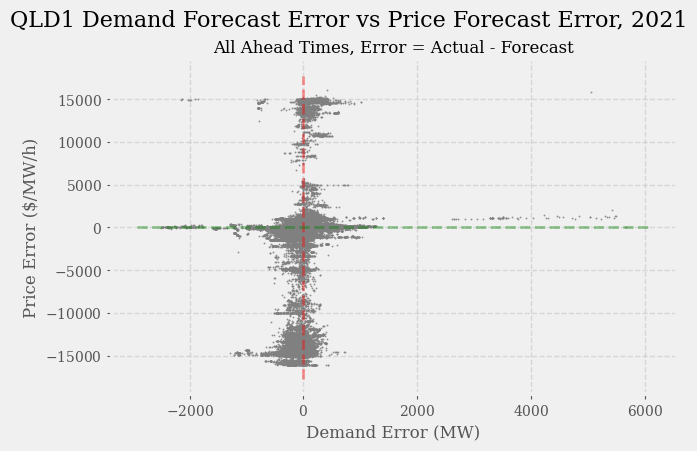

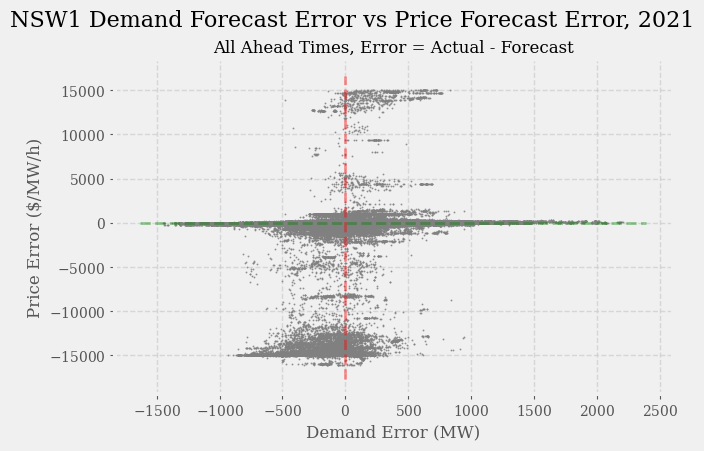

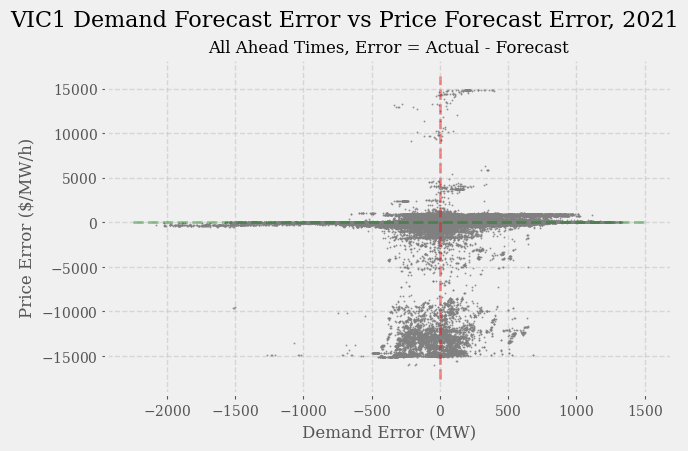

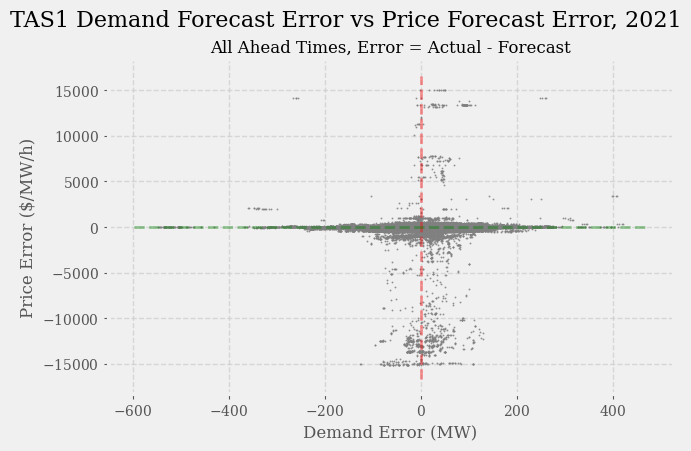

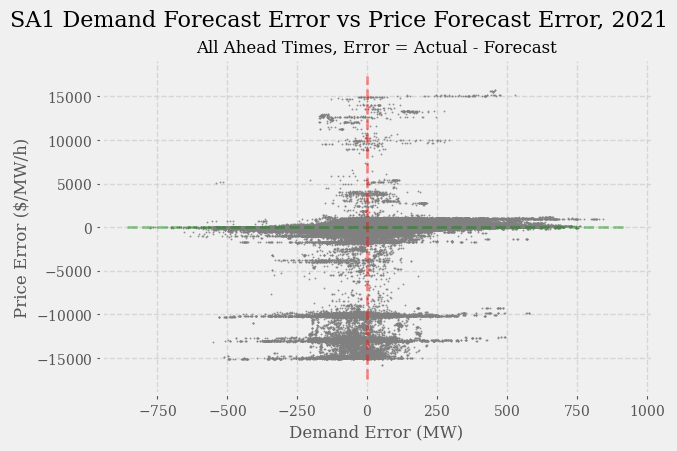

In [25]:
for region in regions:
    region_errors = demand_price_error.query("REGIONID==@region")
    ax = region_errors.plot.scatter(
        x="demand_error",
        y="price_error",
        s=0.75,
        xlabel="Demand Error (MW)",
        ylabel="Price Error ($/MW/h)",
        c="grey",
        alpha=0.7
    )
    plt.suptitle(f"{region} Demand Forecast Error vs Price Forecast Error, 2021", fontsize=16)
    plt.title("All Ahead Times, Error = Actual - Forecast",fontsize=12)
    (ymin, ymax) = ax.get_ylim()
    (xmin, xmax) = ax.get_xlim()
    plt.vlines(0.0, ymin, ymax, ls="--", color="r", alpha=0.4)
    plt.hlines(0.0, xmin, xmax, ls="--", color="g", alpha=0.4)
    plt.tight_layout()

#### Regional scatter plots, with ahead times > 1 hour

A large number of the points in the previous charts are for ahead times less than 1 hour (because each forecasted time will have 12 `P5MIN` forecasts that are within an hour).

In the next few charts, we'll focus on ahead times > 1 hour (`PREDISPATCH`) and color each data point based on its ahead time.

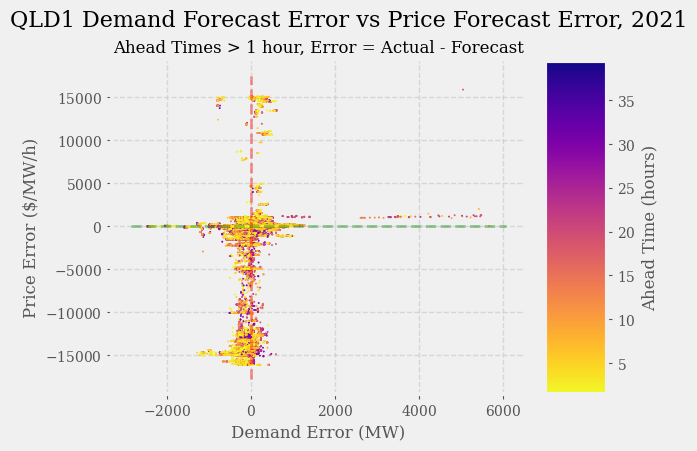

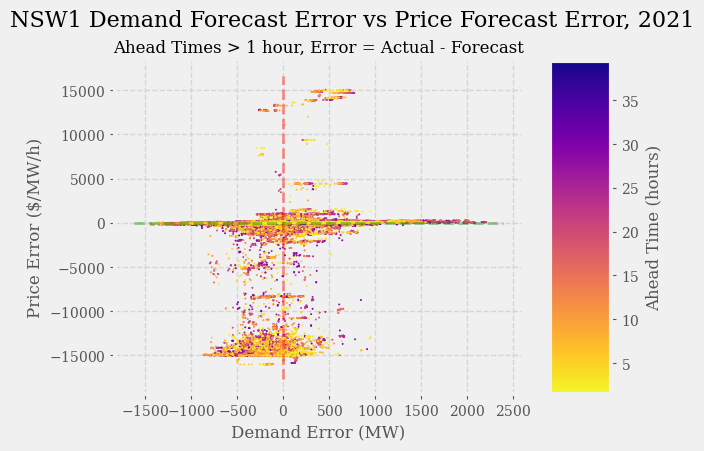

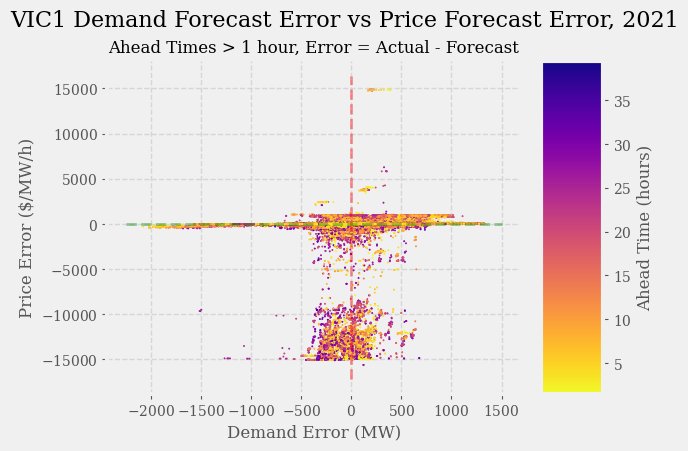

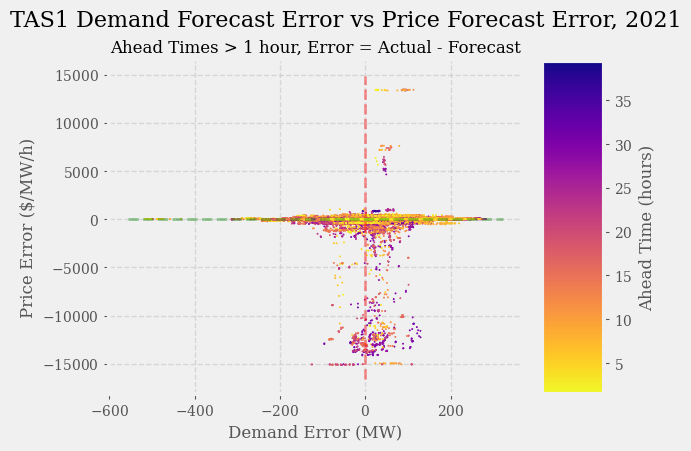

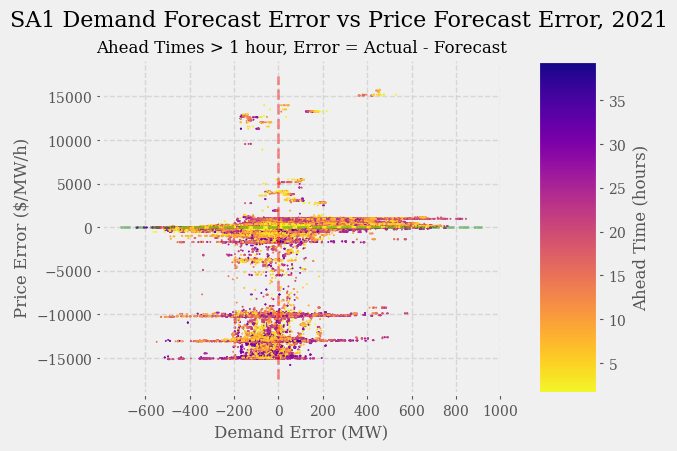

In [26]:
for region in regions:
    region_errors = demand_price_error.query("REGIONID==@region")
    # only retain ahead times > 1 hour
    region_errors = region_errors[region_errors["ahead_time"] > timedelta(hours=1)]
    # convert ahead time to hours
    region_errors["Ahead Time (hours)"] = (
        region_errors.loc[:, "ahead_time"].astype(int) * 10**-9 / 60.0 / 60.0
    )
    fig, ax = plt.subplots()
    im = ax.scatter(
        x=region_errors["demand_error"],
        y=region_errors["price_error"],
        s=0.75,
        c=region_errors["Ahead Time (hours)"],
        cmap=plt.get_cmap("plasma_r"),
    )
    (ymin, ymax) = ax.get_ylim()
    (xmin, xmax) = ax.get_xlim()
    ax.set_xlabel("Demand Error (MW)")
    ax.set_ylabel("Price Error ($/MW/h)")
    plt.suptitle(f"{region} Demand Forecast Error vs Price Forecast Error, 2021", fontsize=16)
    plt.title("Ahead Times > 1 hour, Error = Actual - Forecast",fontsize=12)
    plt.vlines(0.0, ymin, ymax, ls="--", color="r", alpha=0.4)
    plt.hlines(0.0, xmin, xmax, ls="--", color="g", alpha=0.4)
    plt.tight_layout()
    fig.colorbar(im, ax=ax, label="Ahead Time (hours)")

#### What about closer to real-time?

The previous charts include errors across all ahead times. **What about if we look at errors 5 minutes ahead of real time?**

We can see that price errors can be significant 5 minutes ahead of dispatch, even if demand forecasts are roughly right. There are several factors that could account for this:

1. Renewable energy forecast accuracy
2. Dispatch vs. 5MPD constraint formulations
3. Sudden outages
4. Participant rebidding

For more information, see the last page of the [pre-dispatch standard operating procedure](https://www.aemo.com.au/-/media/files/electricity/nem/security_and_reliability/power_system_ops/procedures/so_op_3704-predispatch.pdf?la=en).

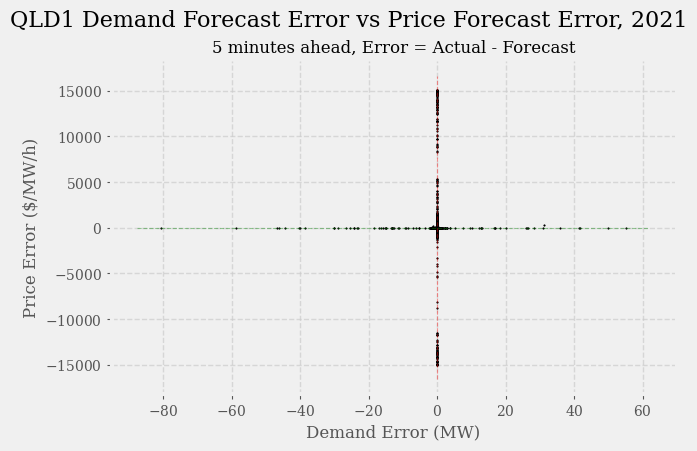

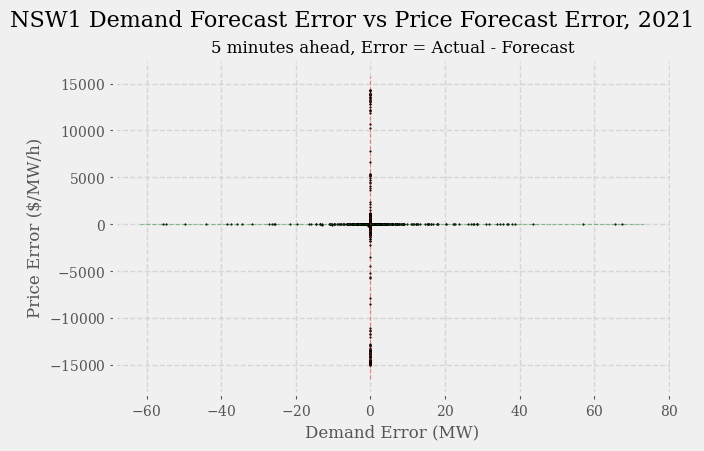

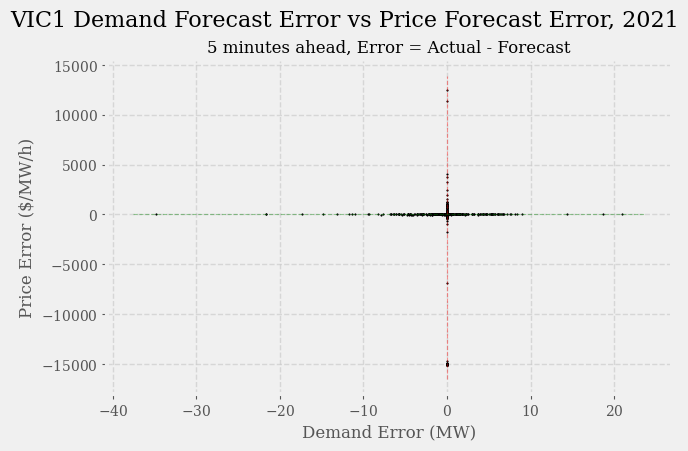

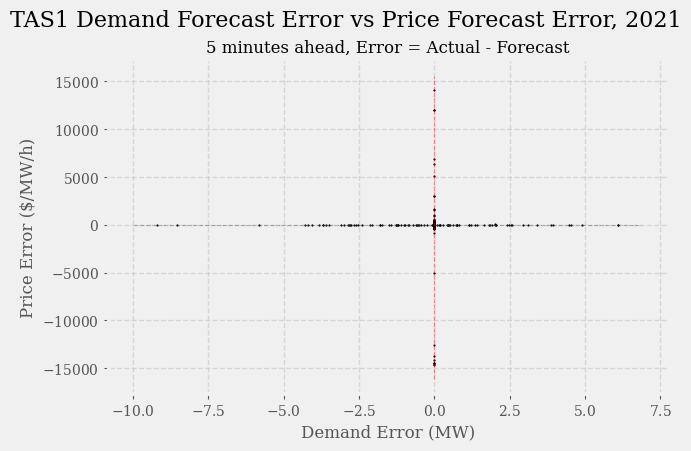

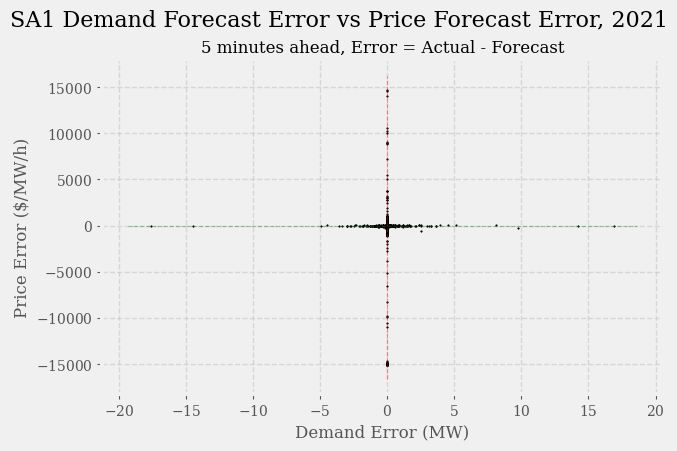

In [27]:
for region in regions:
    region_errors = demand_price_error.query("REGIONID==@region")
    region_errors = region_errors[region_errors["ahead_time"] == timedelta(minutes=5)]
    ax = region_errors.plot.scatter(
        x="demand_error",
        y="price_error",
        s=1,
        xlabel="Demand Error (MW)",
        ylabel="Price Error ($/MW/h)",
        color="black"
    )
    plt.suptitle(f"{region} Demand Forecast Error vs Price Forecast Error, 2021", fontsize=16)
    plt.title("5 minutes ahead, Error = Actual - Forecast",fontsize=12)
    (ymin, ymax) = ax.get_ylim()
    (xmin, xmax) = ax.get_xlim()
    plt.vlines(0.0, ymin, ymax, ls="--", color="r", alpha=0.4, lw=0.8)
    plt.hlines(0.0, xmin, xmax, ls="--", color="g", alpha=0.4, lw=0.8)
    plt.tight_layout()